# ¿Como afecta el clima  a la cantidad de viajes que hay por dia?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendarUSFH
import calendar

%matplotlib inline

plt.style.use('default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (12, 4)

In [2]:
weather = pd.read_csv('data/weather.csv',dtype={'zip_code': str})

In [3]:
trips = pd.read_csv('data/trip.csv')

In [4]:
def splitDate(date):
    lineSplit = date.split('/')
    return str(lineSplit[2]) +\
        str(lineSplit[0] if int(lineSplit[0]) >= 10 else '0' + str(lineSplit[0])) + \
        str(lineSplit[1] if int(lineSplit[1]) >= 10 else '0' + str(lineSplit[1]) )

#### Tranformamos las fechas en un formato que sea mas facil de manejar

In [5]:
weather['date'] = weather['date'].apply(lambda x : pd.to_datetime(splitDate(x)))

In [6]:
trips['start_date'] = trips['start_date'].apply(lambda x : pd.to_datetime(splitDate(x.split(' ')[0])) )

In [7]:
weather['precipitation_inches'] = weather['precipitation_inches'].apply(lambda x : 0.005 if (x == 'T') else float(x))

weather = weather[weather.precipitation_inches.isnull() == False]

weather = weather.fillna(0)

weather['events'] = weather['events'].apply(lambda x : 'Normal' if x == 0 else x)
weather['events'] = weather['events'].apply(lambda x : 'Rain' if x == 'rain' else x)

#### Vamos a hacer un Join en el cual vamos a tener la duracion promedio de los viajes en un determinado dia, y ademas la cantidad de viajes en un dia

In [8]:
tripsWithReduceDuration = trips[(trips['duration'] < 7200) & (trips['duration'] > 60)]

In [9]:
tripsByDay = tripsWithReduceDuration[['start_date']]
tripsByDay.rename(columns={'start_date' : 'date'},inplace=True)

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [10]:
tripsByDay = tripsByDay.assign(tripsByDay = 1).groupby(by='date').sum()
tripsByDay = tripsByDay.reset_index()

In [11]:
durationTripsByDay = tripsWithReduceDuration[['start_date','duration']]
durationTripsByDay.rename(columns={'start_date' : 'date','duration' : 'meanDurationByDay'},inplace=True)

In [12]:
durationTripsByDay = durationTripsByDay.groupby(by='date').mean().reset_index()

In [13]:
durationTripsByDay.sample(5)

,date,meanDurationByDay
325,2014-07-20,1151.292011
17,2013-09-15,1135.657609
316,2014-07-11,655.006629
518,2015-01-29,563.791311
568,2015-03-20,602.731830


In [14]:
durationAndTripsByDay = pd.merge(tripsByDay,durationTripsByDay, on='date',how='left')
durationAndTripsByDay.sample()
durationAndTripsByDay['numberdayofweek'] = durationAndTripsByDay['date'].apply(lambda x : x.dayofweek)
durationAndTripsByDay['dayofweek'] = durationAndTripsByDay['date'].apply(lambda x : calendar.day_name[x.dayofweek])

In [15]:
dataMerge = pd.merge(durationAndTripsByDay, weather, on='date', how='left')
dataMerge.sample()

,date,tripsByDay,meanDurationByDay,numberdayofweek,dayofweek,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
1007,2014-03-18,1129,594.636847,1,Tuesday,73.0,60.0,46.0,41.0,35.0,...,0.0,0.0,15.0,6.0,0.0,0.0,0.0,Normal,2.0,94301


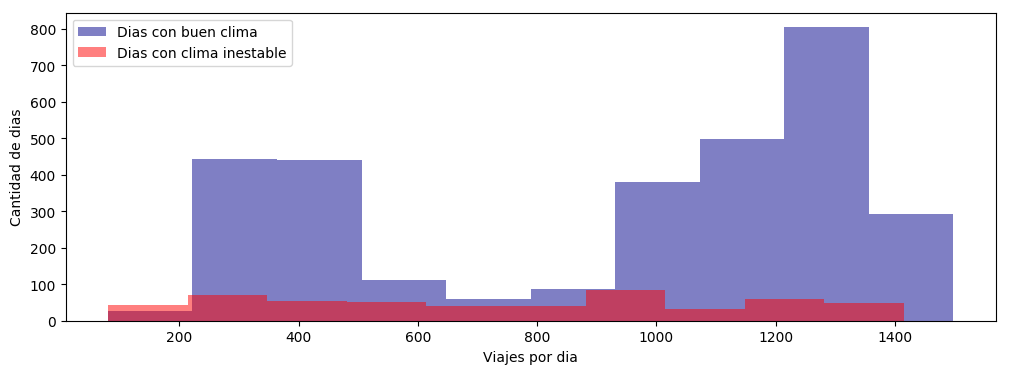

In [16]:
plt.hist(x=dataMerge[dataMerge['events'] == 'Normal']['tripsByDay'],color='darkblue',alpha=0.5)
plt.hist(x=dataMerge[dataMerge['events'] != 'Normal']['tripsByDay'],color='red',alpha=0.5)
plt.xlabel('Viajes por dia')
plt.ylabel('Cantidad de dias')
plt.legend(['Dias con buen clima','Dias con clima inestable'])

Se ve como hay una marcada diferencia, eso puede ser producto de que la muestra de los viajes con clima estable es mucho mayor a la de los dias inestable. Vamos a corregir esto usando una miestra igual.

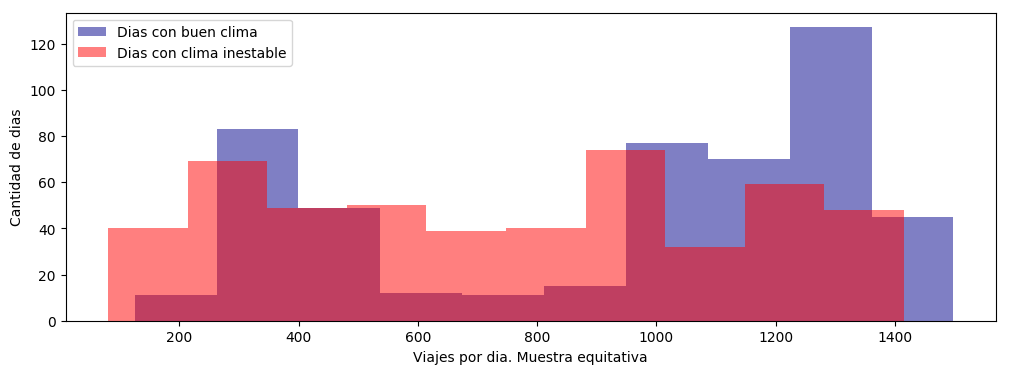

In [17]:
plt.hist(x=dataMerge[dataMerge['events'] == 'Normal']['tripsByDay'].sample(500),color='darkblue',alpha=0.5)
plt.hist(x=dataMerge[dataMerge['events'] != 'Normal']['tripsByDay'].sample(500),color='red',alpha=0.5)
plt.xlabel('Viajes por dia. Muestra equitativa')
plt.ylabel('Cantidad de dias')
plt.legend(['Dias con buen clima','Dias con clima inestable'])

Como ya sabemos del caso anterior, aqui va a haber un conflicto determinado por la muestra.

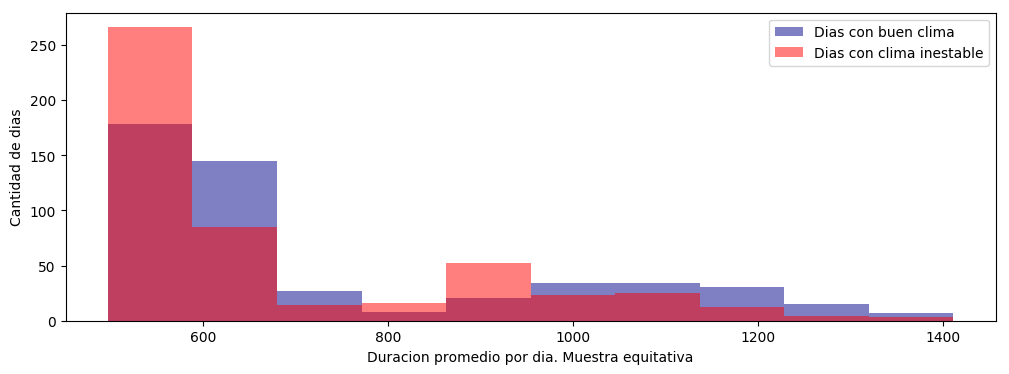

In [18]:
# histtype : {'bar', 'barstacked', 'step',  'stepfilled'}, optional
plt.hist(x=dataMerge[dataMerge['events'] == 'Normal']['meanDurationByDay'].sample(500),color='darkblue',alpha=0.5)
plt.hist(x=dataMerge[dataMerge['events'] != 'Normal']['meanDurationByDay'].sample(500),color='red',alpha=0.5)
plt.xlabel('Duracion promedio por dia. Muestra equitativa')
plt.ylabel('Cantidad de dias')
plt.legend(['Dias con buen clima','Dias con clima inestable'])

In [19]:
plt.rcParams['figure.figsize'] = (15, 5)

durationAndTripsByWeekDay = pd.merge(durationAndTripsByDay, weather, on='date', how='left')

In [20]:
correlationData = pd.merge(durationAndTripsByDay, weather, on='date', how='left')
correlationData.sample()

,date,tripsByDay,meanDurationByDay,numberdayofweek,dayofweek,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
679,2014-01-11,234,765.222222,5,Saturday,59.0,51.0,43.0,50.0,44.0,...,10.0,10.0,20.0,3.0,24.0,0.0,4.0,Normal,349.0,95113


In [21]:
# Relationship between columns
correlationData[['tripsByDay','meanDurationByDay','numberdayofweek','mean_temperature_f', 'mean_dew_point_f', 'mean_humidity', 'mean_sea_level_pressure_inches',\
                 'mean_visibility_miles', 'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',\
                 'cloud_cover']].corr().abs()

,tripsByDay,meanDurationByDay,numberdayofweek,mean_temperature_f,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover
tripsByDay,1.000000,0.797500,0.684064,0.233733,0.141996,0.051457,0.097514,0.064926,0.041974,0.041209,0.131320,0.061177
meanDurationByDay,0.797500,1.000000,0.712849,0.093335,0.056387,0.016870,0.024100,0.052761,0.016134,0.010779,0.068889,0.113279
numberdayofweek,0.684064,0.712849,1.000000,0.001263,0.018123,0.032006,0.028222,0.013868,0.018682,0.006067,0.003466,0.001630
mean_temperature_f,0.233733,0.093335,0.001263,1.000000,0.617477,0.068019,0.509276,0.187408,0.274603,0.015293,0.070142,0.035683
mean_dew_point_f,0.141996,0.056387,0.018123,0.617477,1.000000,0.677437,0.405035,0.091269,0.233726,0.064003,0.051778,0.215646
mean_humidity,0.051457,0.016870,0.032006,0.068019,0.677437,1.000000,0.060757,0.145302,0.011083,0.032615,0.145442,0.376591
mean_sea_level_pressure_inches,0.097514,0.024100,0.028222,0.509276,0.405035,0.060757,1.000000,0.093653,0.391993,0.155546,0.176203,0.162971
mean_visibility_miles,0.064926,0.052761,0.013868,0.187408,0.091269,0.145302,0.093653,1.000000,0.173664,0.072271,0.181641,0.166172
mean_wind_speed_mph,0.041974,0.016134,0.018682,0.274603,0.233726,0.011083,0.391993,0.173664,1.000000,0.337248,0.132158,0.326831
max_gust_speed_mph,0.041209,0.010779,0.006067,0.015293,0.064003,0.032615,0.155546,0.072271,0.337248,1.000000,0.158793,0.117317


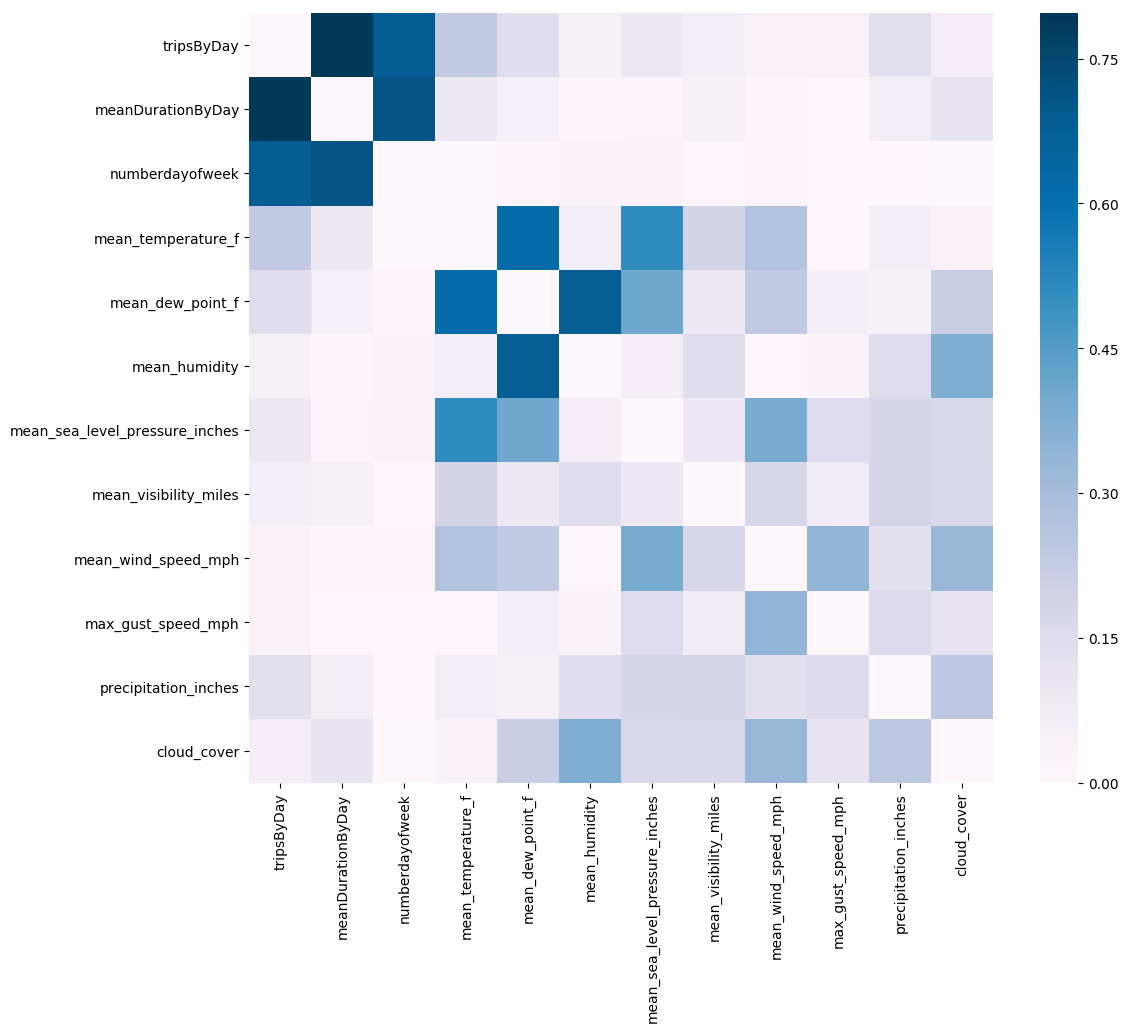

In [22]:
#'mean_temperature_f', 'mean_dew_point_f', 'mean_humidity', 'mean_sea_level_pressure_inches',
#'mean_visibility_miles', 'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches','cloud_cover'

fig, ax = plt.subplots(figsize=(12,10));        # Sample figsize in inches
cor = correlationData[['tripsByDay','meanDurationByDay','numberdayofweek','mean_temperature_f', 'mean_dew_point_f', 'mean_humidity', 'mean_sea_level_pressure_inches',\
                 'mean_visibility_miles', 'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',\
                 'cloud_cover']].corr().abs()
cor.values[[np.arange(12)]*2] = 0
sns.heatmap(cor,cmap='PuBu');

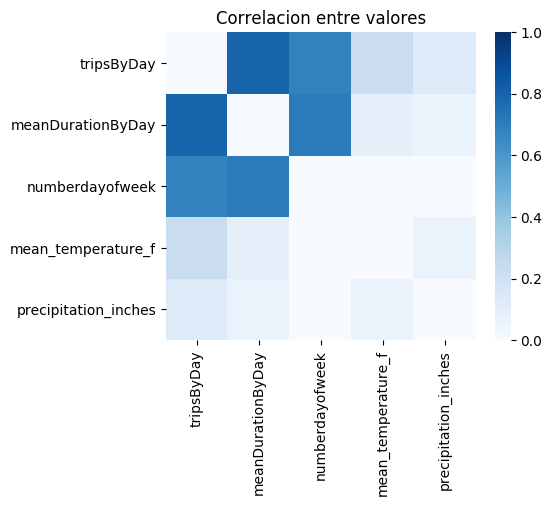

In [23]:
fig, ax = plt.subplots(figsize=(5,4));        # Sample figsize in inches
cor = correlationData[['tripsByDay','meanDurationByDay','numberdayofweek','mean_temperature_f', 'precipitation_inches']]\
        .corr().abs()

    
ax = plt.axes()
ax.set_title('Correlacion entre valores')
cor.values[[np.arange(5)]*2] = 0
sns.heatmap(cor,cmap='Blues',vmin=0, vmax=1,ax=ax)


In [24]:
durationAndTripsByDay.sample()

,date,tripsByDay,meanDurationByDay,numberdayofweek,dayofweek
395,2014-09-28,337,896.385757,6,Sunday


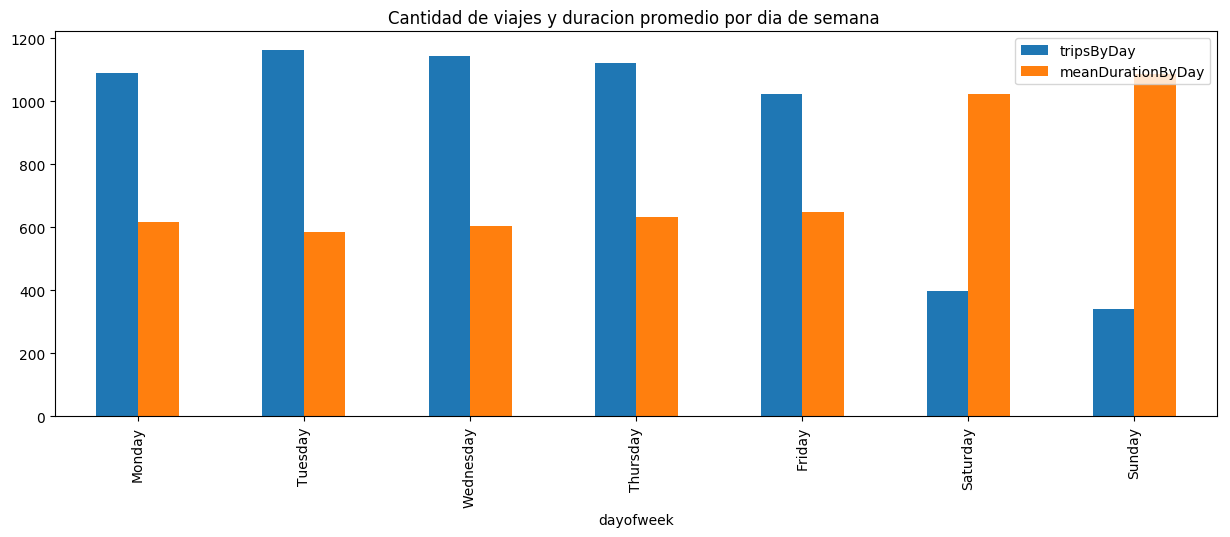

In [25]:
dataMergeByDay = durationAndTripsByDay.groupby(by=['numberdayofweek','dayofweek']).mean().reset_index()
dataMergeByDay.plot(kind='bar',x='dayofweek',y=['tripsByDay','meanDurationByDay'],title='Cantidad de viajes y duracion promedio por dia de semana ')

In [26]:
tripsMean = pd.merge(durationAndTripsByDay, weather, on='date', how='left')

In [27]:
meanValueOfMeanTF = tripsMean.mean_temperature_f.mean()

In [28]:
tripsMean['mean_temperature_f'] = tripsMean['mean_temperature_f'].apply(lambda x : float(x)/float(meanValueOfMeanTF) )

In [29]:
tripsMean.tripsByDay.mean()

896.95332969432309

In [30]:
meanValueOfTBD = tripsMean.tripsByDay.mean()
tripsMean['tripsByDay'] = tripsMean['tripsByDay'].apply(lambda x : float(x)/float(meanValueOfTBD) )
tripsMean.sample()

,date,tripsByDay,meanDurationByDay,numberdayofweek,dayofweek,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
3196,2015-05-30,0.463792,1010.348558,5,Saturday,68.0,0.978815,53.0,55.0,52.0,...,9.0,7.0,18.0,6.0,23.0,0.0,5.0,Normal,346.0,94063


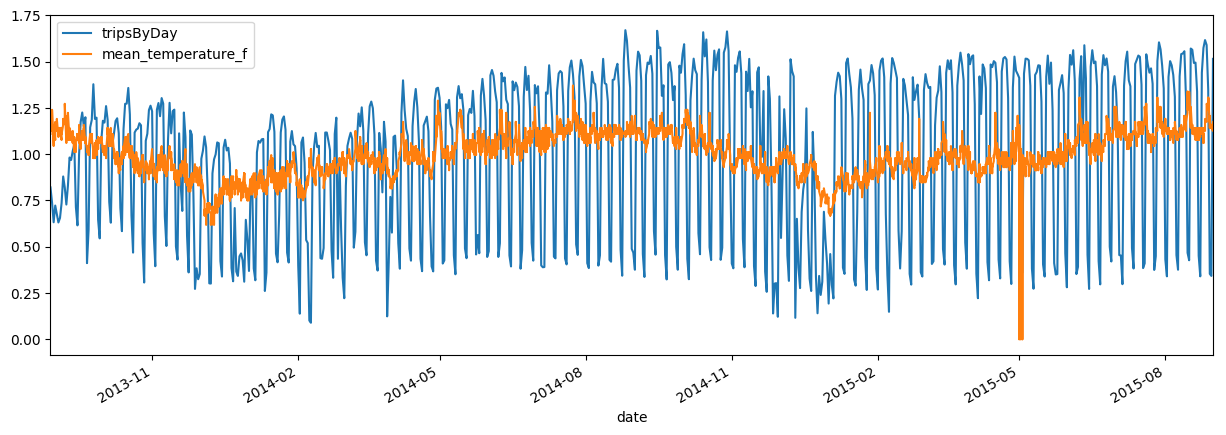

In [31]:
tripsMean.plot(x='date',y=['tripsByDay','mean_temperature_f'])

In [32]:
dataMerge[ dataMerge['mean_temperature_f'] < 0.50 ]

,date,tripsByDay,meanDurationByDay,numberdayofweek,dayofweek,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
3053,2015-05-01,1267,638.468035,4,Friday,0.0,0.0,0.0,0.0,0.0,...,10.0,10.0,16.0,6.0,22.0,0.0,0.0,Normal,340.0,94041
3058,2015-05-02,321,915.489097,5,Saturday,0.0,0.0,0.0,0.0,0.0,...,10.0,9.0,14.0,7.0,18.0,0.0,3.0,Normal,356.0,94041
3063,2015-05-03,323,1113.860681,6,Sunday,0.0,0.0,0.0,0.0,0.0,...,10.0,10.0,17.0,7.0,0.0,0.0,2.0,Normal,23.0,94041


In [33]:
weather[weather['date'] == pd.to_datetime('20150501')]

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
2082,2015-05-01,76.0,65.0,53.0,54.0,51.0,48.0,93.0,71.0,49.0,...,10.0,9.0,20.0,9.0,23.0,0.0,2.0,Normal,312.0,94107
2447,2015-05-01,78.0,68.0,57.0,55.0,48.0,43.0,82.0,55.0,34.0,...,10.0,10.0,13.0,3.0,16.0,0.0,0.0,Normal,329.0,94063
2812,2015-05-01,77.0,67.0,57.0,61.0,57.0,50.0,88.0,68.0,50.0,...,10.0,10.0,21.0,9.0,0.0,0.0,0.0,Normal,347.0,94301
3177,2015-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,10.0,16.0,6.0,22.0,0.0,0.0,Normal,340.0,94041
3542,2015-05-01,84.0,71.0,57.0,53.0,48.0,41.0,86.0,56.0,25.0,...,10.0,10.0,18.0,7.0,22.0,0.0,1.0,Normal,251.0,95113


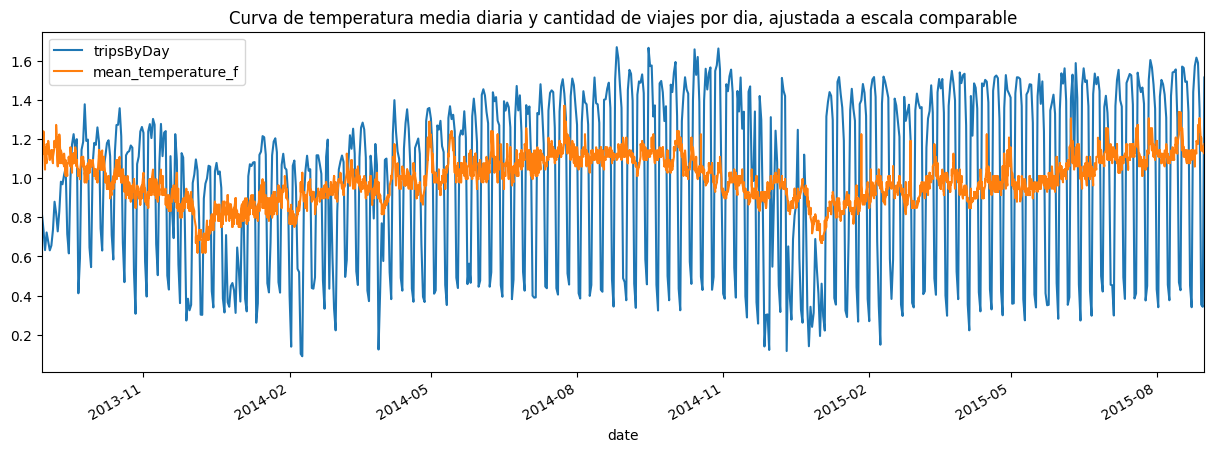

In [34]:
tripsMean[tripsMean['mean_temperature_f'] > 0].plot(x='date',y=['tripsByDay','mean_temperature_f'],title='Curva de temperatura media diaria y cantidad de viajes por dia, ajustada a escala comparable')